In [1]:
# Imports
%config InlineBackend.figure_format = 'retina'
%pylab inline
import sys
sys.path.append('../../src/')
from helpers import *
from plothelpers import *
from AdditiveBaseGame import *
from random import sample
import json, pickle
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


# Preprocessing

In [5]:
# Migrate data
for nmax in range(11, 111):
    res = pickle.load(open(f'HUR07/HUR07-nmax-{nmax}.pickle', 'rb'))
    fav_bases = array(res[0])
    successes = array(res[1])
    base_counts = fav_bases.sum(axis=2)
    num_bases = fav_bases.sum(axis=3).sum(axis=2)
    num_unique_bases = (fav_bases.sum(axis=2) > 0).sum(axis=2)
    
    _base = os.path.join('../../results/HUR07', f'HUR07-nmax-{nmax}')
    np.save(_base+'-base-counts.npy', base_counts, allow_pickle=False)
    np.savetxt(_base+'-num-bases.txt.gz', array(num_bases))
    np.savetxt(_base+'-num-unique-bases.txt.gz', array(num_unique_bases))
    np.savetxt(_base+'-successes.txt.gz', array(successes))
    
    params = json.load(open(f'HUR07/HUR07-nmax-{nmax}-setup.json', 'r'))
    json.dump(params, open(_base+'-params.json', 'w'))

In [97]:
# Preprocess raw data
data, cols = [], []
for nmax in range(11,111):
    res = load_ABG_simulation('../../results/HUR07/', f'HUR07-nmax-{nmax}')
    base_counts, _, _, _, params = res
    
    final_states = base_counts[:,-1,:]
    data += final_states.mean(axis=0).tolist()
    data += final_states.std(axis=0).tolist()
    
    cols += [(f'nmax-{nmax}', f'base-{b}', 'mean') for b in params['bases']]
    cols += [(f'nmax-{nmax}', f'base-{b}', 'std') for b in params['bases']]

    
data = pd.DataFrame(data)
data.index = pd.MultiIndex.from_tuples(cols)

# Reformat df/
data = data.unstack(level=[1,2])
data = data[0]
data.index = data.index.str.replace('nmax-', '').astype(int)
data.sort_index(axis=0, inplace=True)
data = data.reindex_axis(sorted(data.columns), axis=1)
data.index.name='nmax'

data.to_csv('../../results/HUR07/HUR07.csv')
data.to_csv('HUR07.csv')

# Plot

In [99]:
data = pd.read_csv('HUR07.csv', header=[0,1], index_col=0)

In [172]:
# Compute num expressions
def num_expressions(n, b, B, simplify=True):
    if n > b*b + B: return 0
    if simplify and n%b == 0: return 1 
    return 2 if n%b <= B-b else 1

B = 10
simplify = True
exprs = []
for n_max in data.index:
    counts = []
    for b in [6,7,8,9,10]:
        nums = arange(11, n_max+1)
        count = sum([num_expressions(n, b, B, simplify) for n in nums])
        counts.append(count)
        
    exprs.append(counts)

# Normalize results
exprs = array(exprs)
exprs = exprs/exprs.sum(axis=1)[:,np.newaxis]

# Exponentiated version
exprs2 = (exprs**1) / (exprs**1).sum(axis=1)[:, np.newaxis]

In [173]:
# Means 
means = data.reorder_levels([1,0], axis=1)['mean']
means = means.divide(means.sum(axis=1), axis=0)
means.columns = means.columns.str.replace('base-','').astype(int)
means.sort_index(axis=1, inplace=True)

/Users/Bas/anaconda/envs/thesis2/lib/python3.6/site-packages/matplotlib/__init__.py:938: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


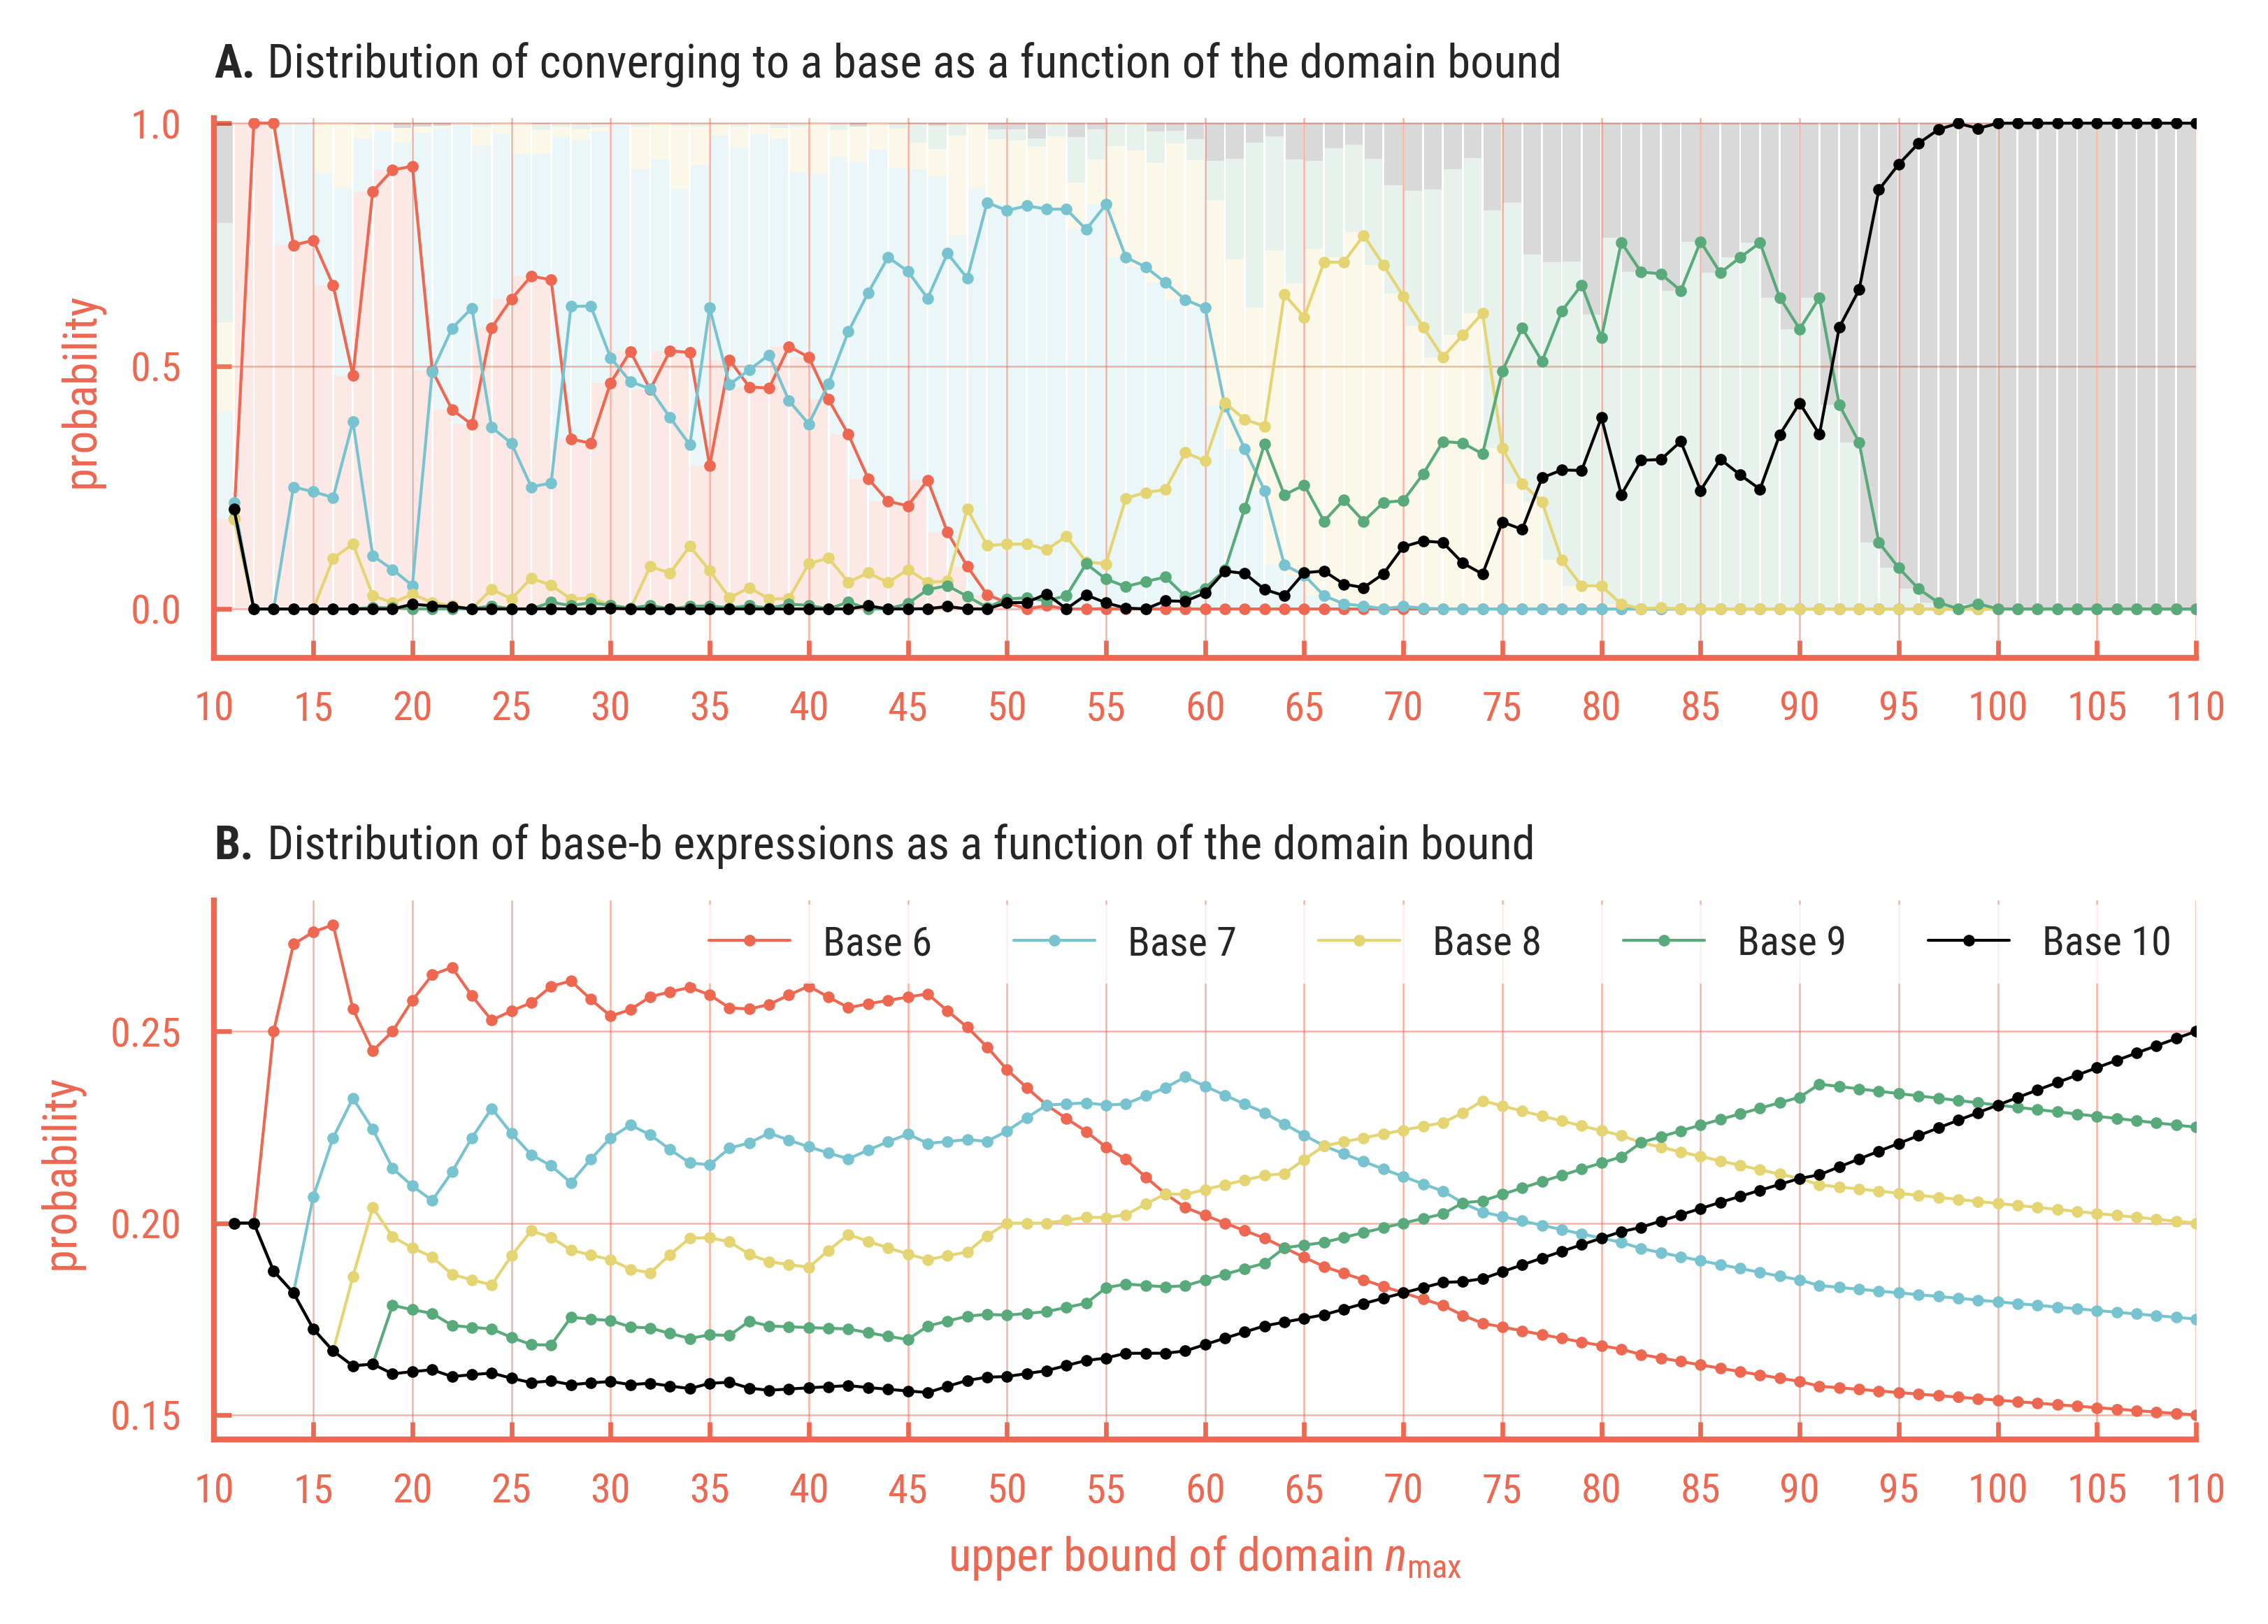

In [171]:
# Plot
figure(figsize=cm2inch(12,8))
xs = means.index

colors = plt.rcParams['axes.color_cycle']
del colors[0]
colors[-1] = '#000000'

if True:
    ax1 = subplot(211)
    for b in range(5):
        plot(xs, means[b+6], 'o-', lw=.5, ms=2, color=colors[b])
        bar(xs-.5, means[b+6], .9, 
            bottom = means.iloc[:,:b].sum(axis=1),
            lw=0, alpha=.15, color=colors[b])

    title('Distribution of converging to a base as a function of the domain bound')
    ylim(-.1,1.01)
    ylabel('probability ')

if True:
    ax2 = subplot(212)
    for i, expr in enumerate(exprs2.T):
        plot(xs, expr, 'o-', lw=.5, ms=2, 
             label=f'Base {i+6}', color=colors[i])
    title('Distribution of base-b expressions as a function of the domain bound')
    xlabel('upper bound of domain $n_{\mathrm{max}}$')
    ylabel('probability ')
    legend(ncol=5, loc='upper right')

restyle_title(ax1,ax2)
for ax in [ax1,ax2]:
    ax.locator_params(nbins=4, axis='y')
    ax.locator_params(nbins=20, axis='x')
    ax.xaxis.grid()
    ax.yaxis.grid()
    ax.set_xlim(10, 110)
sns.despine()

subplots_adjust(left=0, bottom=0, right=1, top=1, hspace=.45)
savefig('HUR07-results.pdf', bbox_inches='tight')
copyfig('HUR07-results.pdf')